<a href="https://colab.research.google.com/github/efeecllk/Transformers/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def f(x):
  return 3*x**2 + 5*x + 4

In [3]:
f(2.0)

26.0

In [4]:
xs = np.arange(-5,5,0.40)
xs

array([-5. , -4.6, -4.2, -3.8, -3.4, -3. , -2.6, -2.2, -1.8, -1.4, -1. ,
       -0.6, -0.2,  0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,
        3.8,  4.2,  4.6])

In [5]:
ys = f(xs)
ys

array([54.  , 44.48, 35.92, 28.32, 21.68, 16.  , 11.28,  7.52,  4.72,
        2.88,  2.  ,  2.08,  3.12,  5.12,  8.08, 12.  , 16.88, 22.72,
       29.52, 37.28, 46.  , 55.68, 66.32, 77.92, 90.48])

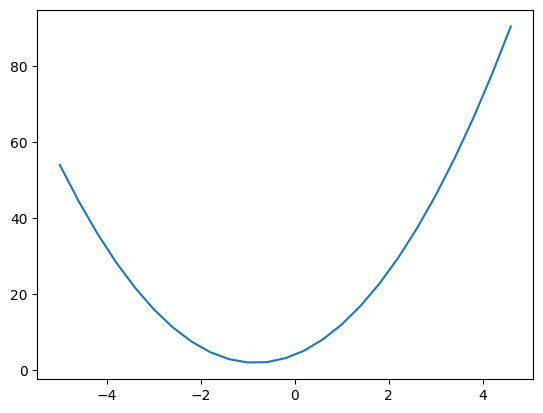

In [6]:
plt.plot(xs,ys)


In [7]:
class Value:
  def __init__(self, data, _children=(), _op=''):
    self.data = data
    self._prev = set(_children)
    self._op= _op

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    out = Value(self.data + other.data, (self,other), '+')
    return out

  def __mul__(self,other):
    out = Value(self.data * other.data,(self,other), '*')
    return out

a = Value(2.0)
b= Value(3.0)
c= Value(-4.0)
# a+b
# b.__add__(a)

d= a*b+c
# (a.__mul__(b)).__add__(c)

d

Value(data=2.0)

In [8]:
d._prev

{Value(data=-4.0), Value(data=6.0)}

In [9]:
d._op

'+'

In [14]:
#Visualize the Value and children
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label="{ data %.4f }" % (n.data, ), shape='record')

    if n._op:
      dot.node(name=uid + n._op, label=n._op)
      dot.edge(uid + n._op, uid)


  for n1, n2 in edges:

        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

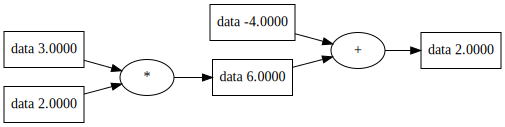

In [15]:
draw_dot(d)
